# Predecir la cantidad de oro extraído

# Contenido <a id='cont'></a>

* [Introducción](#int)
* [Prepara los datos](#pre)
* [Preprocesamiento los datos](#pro)
* [Análisis de datos](#eda)
* [Entrenamiento de modelos](#ent)
* [Conclusiones](#con)

# Introducción <a id='int'></a>

Este trabajo busca preparar un prototipo de un modelo de machine learning para Zyfra. La empresa desarrolla soluciones de eficiencia para la industria pesada. El modelo debe predecir la cantidad de oro extraído del mineral de oro. Disponemos de los datos de extracción y purificación. El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables.

## Objetivo
Crear un modelo para predecir la cantidad de oro extraido del mineral de oro.

## Descripción de datos

Proceso tecnológico:
- Rougher feed — *materia prima*
- Rougher additions (o adiciones de reactivos) - *reactivos de flotación: xantato, sulfato, depresante*
    - Xantato — *promotor o activador de la flotación*
    - Sulfato — *sulfuro de sodio para este proceso en particular*
    - Depresante — *silicato de sodio*
- Rougher process — *flotación*
- Rougher tails — *residuos del producto*
- Float banks — *instalación de flotación*
- Cleaner process — *purificación*
- Rougher Au — *concentrado de oro rougher*
- Final Au — *concentrado de oro final*

Parámetros de las etapas:
- air amount — *volumen de aire*
- fluid levels
- feed size — *tamaño de las partículas de la alimentación*
- feed rate

**Denominación de las características:**

Así es como se denominan las características: 
- `[stage].[parameter_type].[parameter_name]`. Ejemplo: `rougher.input.feed_ag`

Valores posibles para `[stage]`:
- rougher — *flotación*
- primary_cleaner — *purificación primaria*
- secondary_cleaner — *purificación secundaria*
- final — *características finales*

Valores posibles para `[parameter_type]`:
- input — *parámetros de la materia prima*
- output — *parámetros del producto*
- state — *parámetros que caracterizan el estado actual de la etapa*
- calculation — *características de cálculo*

Necesitamos predecir dos valores:
- La recuperación del concentrado rougher `rougher.output.recovery`.
- La recuperación final del concentrado `final.output.recovery`.


# Preparación de datos <a id='pre'></a>

In [1]:
%load_ext watermark
%watermark


Last updated: 2023-04-10T11:16:05.557456-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.11.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit



Importamos librerías:

In [2]:
# generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import interpolate

# machine learning
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics as met
from sklearn.metrics import mean_absolute_error


Los datos se almacenan en tres archivos. Cargamos datasets:

In [3]:
# carga de datos
try:
    data_train = pd.read_csv('gold_recovery_train.csv')
    data_test = pd.read_csv('gold_recovery_test.csv')
    data = pd.read_csv('gold_recovery_full.csv')
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    data = pd.read_csv('/datasets/gold_recovery_full.csv')


In [4]:
data.head()


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Examinaremos los datos: dimensiones, tipos de datos, duplicados, datos ausentes.

In [5]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [6]:
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [7]:
data_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

Miremos como están particionados los datasets, nos guiaremos por la fecha.

In [8]:
print(f'Data       "date"  from {data.date.min()}  to {data.date.max()}')
print(
    f'Data_train "date"  from {data_train.date.min()}  to {data_train.date.max()}')
print(
    f'Data_test  "date"  from {data_test.date.min()}  to {data_test.date.max()}')


Data       "date"  from 2016-01-15 00:00:00  to 2018-08-18 10:59:59
Data_train "date"  from 2016-01-15 00:00:00  to 2018-08-18 10:59:59
Data_test  "date"  from 2016-09-01 00:59:59  to 2017-12-31 23:59:59


In [9]:
# Size datasets and data type
print(f'- Dataset full Size={data.shape}. Data type columns:')
print(data.dtypes.value_counts())

print(f'\n- Dataset train Size={data_train.shape}. Data type columns:')
print(data_train.dtypes.value_counts())

print(f'\n- Dataset test Size={data_test.shape}. Data type columns:')
print(data_test.dtypes.value_counts())


- Dataset full Size=(22716, 87). Data type columns:
float64    86
object      1
dtype: int64

- Dataset train Size=(16860, 87). Data type columns:
float64    86
object      1
dtype: int64

- Dataset test Size=(5856, 53). Data type columns:
float64    52
object      1
dtype: int64


In [10]:
# Find row duplicates in datasets
print('Duplicated rows: ', data.duplicated().sum(),
      data_train.duplicated().sum(), data_test.duplicated().sum())

# Find row duplicates in the "date" column  of each dataset
print('Duplicated date column: ', data.date.duplicated().sum(),
      data_train.date.duplicated().sum(), data_test.date.duplicated().sum())


Duplicated rows:  0 0 0
Duplicated date column:  0 0 0


*Hallazgos encontrados:*

Observamos el tamaño de cada dataset (filas y columnas). Todas las columnas tienen un tipo de datos flotante, solo la columna `date` es de tipo *object* y debemos cambiar a tipo *datetime*, para que sea mejor el manejo de estos datos.

Observamos que en el dataset de prueba `data_test` faltan 34 columnas.

La columna "date" nos muestra como fueron particionados los dataset de entrenamiento y prueba. En el dataset de entrenamiento vemos datos de 2 años (2016-2017) y en el dataset de prueba vemos datos de 9 meses del 2016. A continuación los detalles:

    - Data       desde 2016-01-15  al 2018-08-18
    - Data_train desde 2016-01-15  al 2017-12-17
    - Data_test  desde 2016-01-15  al 2016-09-14


Ademas, no encontramos registros duplicados en los datasets, tampoco en la columna "date" en cada dataset, es decir las fechas son únicas, no se repiten.

### Revisar cálculo de recuperación

$$
Recovery = \frac { C * (F-T))} { F * (C - T)} * 100\%
$$

- C = `rougher.output.concentrate_au` ó `final.output.concentrate_au`
- F = `rougher.input.feed_au`         ó `primary_cleaner.output.concentrate_au`
- T = `rougher.output.tail_au`        ó `secundary_cleanear.output.tail_au`

In [11]:
def recovery(data, concentrate):
    if concentrate == 'rougher':
        c = data['rougher.output.concentrate_au']
        f = data['rougher.input.feed_au']
        t = data['rougher.output.tail_au']
    elif concentrate == 'final':
        c = data['final.output.concentrate_au']
        f = data['primary_cleaner.output.concentrate_au']
        t = data['secundary_cleanear.output.tail_au']

    recovery = ((c * (f - t)) / (f * (c - t))) * 100
    return recovery


Hemos creado una función para el cálculo de reperación de *concentrado rougher* y *concentrado final*. Usaremos esta función para comprobar que el cálculo de recuperación 'rougher' sea correcto en la característicca `rougher.output.recovery` mediante el conjunto de entrenamiento. Encuentraremos el EAM entre nuestros cálculos y los valores de la característica.

In [12]:
# Calculate recovery concentrate rougher

# We save training data without NaN of column "rougher.output.recovery"
data_train_dep = data_train.dropna(subset=['rougher.output.recovery'])
concentrate = ['rougher', 'final']

rougher_recovery_calculate = recovery(data_train_dep, concentrate[0], )
rougher_recovery_calculate


0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 14287, dtype: float64

In [13]:
# Calculate "ean_absolute_error"
mae = mean_absolute_error(data_train_dep['rougher.output.recovery'],
                          rougher_recovery_calculate)

print(f'Rougher concentrate recovery MAE: {mae:0.10f}')


Rougher concentrate recovery MAE: 0.0000000000


El margen de error es 0, esto quiere decir que el cálculo coincide con los datos de la columna 'rougher.output.recovery'. A continuación podemos observarlo gráficamente.

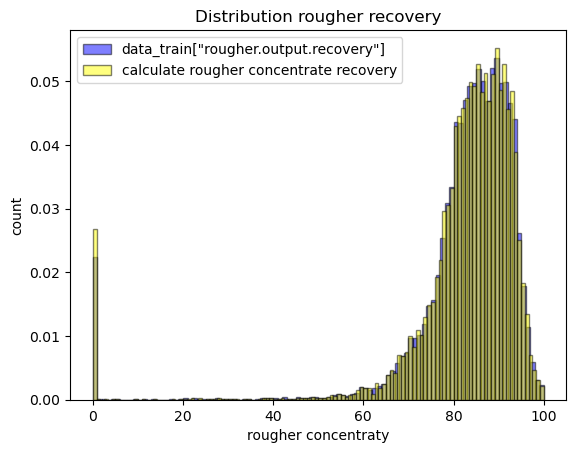

In [14]:
# Graph comparison of results

plt.hist(data_train_dep['rougher.output.recovery'], label='data_train["rougher.output.recovery"]',
         alpha=0.5, color='blue', ec='black', bins=100, density=True)
plt.hist(rougher_recovery_calculate,                label='calculate rougher concentrate recovery',
         alpha=0.5, color='yellow',  ec='black', bins=120, density=True)
plt.xlabel('rougher concentraty')
plt.ylabel('count')
plt.title('Distribution rougher recovery')
plt.legend()
plt.show()


Analizaremos las características no disponibles en el conjunto de prueba a continuación:

In [15]:
missing_columns = data_train.columns[~data_train.columns.isin(
    data_test.columns)]
print(f'Missing columns in data_test: {len(missing_columns)}\n')
print(missing_columns)


Missing columns in data_test: 34

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.outp

In [16]:
# Total columns with output in data_train
len(data_train.columns[data_train.columns.str.contains('output')])


30

Observamos 34 columnas faltantes en el dataset de prueba entre ellas las variables objetivo `rougher.output.recovery` y `final.output.recovery`. Todos los parámetros 'output' faltan (30) y 4 'calculation. Detalle a continuación por étapas:

Etapa "final", parámetro: "output"
- `'final.output.concentrate_ag'`, 
- `'final.output.concentrate_pb'`,
- `'final.output.concentrate_sol'`, 
- `'final.output.concentrate_au'`,
- **`'final.output.recovery'`**, 
- `'final.output.tail_ag'`, 
- `'final.output.tail_pb'`,
- `'final.output.tail_sol'`, 
- `'final.output.tail_au'`,

Etapa "primary_cleaner", parámetro: "output"
- `'primary_cleaner.output.concentrate_ag'`,
- `'primary_cleaner.output.concentrate_pb'`,
- `'primary_cleaner.output.concentrate_sol'`,
- `'primary_cleaner.output.concentrate_au'`,
- `'primary_cleaner.output.tail_ag'`, 
- `'primary_cleaner.output.tail_pb'`,
- `'primary_cleaner.output.tail_sol'`, 
- `'primary_cleaner.output.tail_au'`,

Etapa "rougher", parámetros: "calculation", "output"
- `'rougher.calculation.sulfate_to_au_concentrate'`,
- `'rougher.calculation.floatbank10_sulfate_to_au_feed'`,
- `'rougher.calculation.floatbank11_sulfate_to_au_feed'`,
- `'rougher.calculation.au_pb_ratio'`, 
- `'rougher.output.concentrate_ag'`,
- `'rougher.output.concentrate_pb'`, 
- `'rougher.output.concentrate_sol'`,
- `'rougher.output.concentrate_au'`, 
- **`'rougher.output.recovery'`**,
- `'rougher.output.tail_ag'`, 
- `'rougher.output.tail_pb'`,
- `'rougher.output.tail_sol'`, 
- `'rougher.output.tail_au'`,

Etapa "secondary_cleaner", parámetro: "output"
- `'secondary_cleaner.output.tail_ag'`, 
- `'secondary_cleaner.output.tail_pb'`,
- `'secondary_cleaner.output.tail_sol'`,
- `'secondary_cleaner.output.tail_au']`,

In [17]:
data_train[missing_columns].head()


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,...,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,...,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,...,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,...,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448


# Preprocesamiento de datos <a id='pro'></a>

### Agregación de columnas

A continuación agregaremos las columnas faltantes para el dataset de prueba.

In [18]:
# We fill in the missing columns for data_test in new dataset named "data_test_full_culumns"

# "columns_to_merge" save column names before merge
columns_to_merge = missing_columns.tolist()
columns_to_merge.append('date')

# Merge columns
data_test = data_test.merge(data[columns_to_merge], on='date', how='left')
data_test.shape


(5856, 87)

Ahora vamos a ordenar las columnas en dataset de prueba.

In [19]:
# Sort columns in data_test
data_test = data_test[data_train.columns]

print('data')
display(data.head(1))

print('data_train')
display(data_train.head(1))

print('data_test')
display(data_test.head(1))


data


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


data_train


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.19202,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.84198


data_test


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,7.578381,10.466295,11.990938,40.743891,70.273583,12.688885,3.844413,11.075686,4.537988,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.31785,4.872511,-500.037437,26.705889,-499.709414


Tenemos nuestro data set de prueba completo con las 87 columnas.

### Tipos de datos

Es necesario colocar el tipo de datos *datetime* a la columna `date`.

In [20]:
print(data.date.dtype)
print(data_train.date.dtype)
print(data_test.date.dtype)


object
object
object


In [21]:
# Change data type "object" to "DateTime" in column "date"

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data_train['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

print(data.date.dtype)
print(data_train.date.dtype)
print(data_test.date.dtype)


datetime64[ns]
datetime64[ns]
datetime64[ns]


In [22]:
data.date.head()


0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
3   2016-01-15 03:00:00
4   2016-01-15 04:00:00
Name: date, dtype: datetime64[ns]

La columna `date` se encuentra lista, con tipo de dato 'datetime' en cada dataset.

### Valores ausentes <a id='nan'></a>

Vamos a revisar los NaN y realizar el tratamiento correspondiente.

### NaN en variables objetivo

Las variables objetivos a predecir son **`rougher.output.recovery`**, **`final.output.recovery`** por lo que primeramente, revisaremos los valores ausentes en estas columnas y eliminaremos los registros pertenecientes a estos NaN.

In [23]:
# NaN en targets before to delete:
print('data')
print(data[['rougher.output.recovery', 'final.output.recovery']].isna().sum())
print('\ndata_train')
print(data_train[['rougher.output.recovery',
      'final.output.recovery']].isna().sum())
print('\ndata_test')
print(data_test[['rougher.output.recovery',
      'final.output.recovery']].isna().sum())


data
rougher.output.recovery    3119
final.output.recovery      1963
dtype: int64

data_train
rougher.output.recovery    2573
final.output.recovery      1521
dtype: int64

data_test
rougher.output.recovery    546
final.output.recovery      442
dtype: int64


In [24]:
# drop NaN in data
data = data.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

# drop NaN in data_train
data_train = data_train.dropna(
    subset=['rougher.output.recovery', 'final.output.recovery'])

# drop NaN in data_test
data_test = data_test.dropna(
    subset=['rougher.output.recovery', 'final.output.recovery'])


In [25]:
# NaN en targets after to delete:
print('data')
print(data[['rougher.output.recovery', 'final.output.recovery']].isna().sum())
print('\ndata_train')
print(data_train[['rougher.output.recovery',
      'final.output.recovery']].isna().sum())
print('\ndata_test')
print(data_test[['rougher.output.recovery',
      'final.output.recovery']].isna().sum())


data
rougher.output.recovery    0
final.output.recovery      0
dtype: int64

data_train
rougher.output.recovery    0
final.output.recovery      0
dtype: int64

data_test
rougher.output.recovery    0
final.output.recovery      0
dtype: int64


### NaN en las características

Antes de tratar los NaN veamos por columna como están distribuidos en cada dataset.

In [26]:
# Data full
print(data.isna().sum().sort_values(ascending=False).head(20))


secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
final.output.concentrate_sol                 211
rougher.input.feed_size                      145
primary_cleaner.output.concentrate_pb        116
primary_cleaner.input.xanthate               104
final.output.tail_pb                         101
rougher.input.feed_pb                        100
rougher.input.feed_sol                        99
primary_cleaner.output.tail_sol               62
rougher.input.floatbank11_sulfate             44
primary_cleaner.input.depressant              37
rougher.input.floatbank10_sulfate             34
primary_cleaner.input.sulfate                 24
rougher.output.concentrate_sol                23
secondary_cleaner.state.floatbank2_b_air      23
primary_cleaner.output.tail_pb                21
dtype: int64


In [27]:
# Data train
print(data_train.isna().sum().sort_values(ascending=False).head(20))


secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
primary_cleaner.input.xanthate               100
rougher.input.feed_pb                        100
final.output.tail_pb                         100
primary_cleaner.output.concentrate_pb         86
rougher.input.feed_sol                        78
primary_cleaner.output.tail_sol               46
rougher.input.floatbank11_sulfate             36
primary_cleaner.input.depressant              32
rougher.input.floatbank10_sulfate             29
rougher.output.concentrate_sol                22
secondary_cleaner.state.floatbank2_b_air      21
primary_cleaner.input.sulfate                 20
primary_cleaner.output.tail_pb                15
dtype: int64


In [28]:
# Data test
print(data_test.isna().sum().sort_values(ascending=False).head(20))


secondary_cleaner.output.tail_sol           143
primary_cleaner.output.concentrate_sol       84
primary_cleaner.output.concentrate_pb        30
rougher.input.floatbank11_xanthate           25
rougher.input.feed_sol                       21
primary_cleaner.output.tail_sol              16
secondary_cleaner.state.floatbank3_a_air      9
rougher.input.floatbank11_sulfate             8
primary_cleaner.output.tail_pb                6
rougher.input.floatbank10_sulfate             5
primary_cleaner.input.depressant              5
primary_cleaner.input.sulfate                 4
primary_cleaner.input.xanthate                4
secondary_cleaner.state.floatbank2_a_air      3
rougher.input.feed_rate                       3
primary_cleaner.output.tail_ag                3
secondary_cleaner.output.tail_pb              2
secondary_cleaner.state.floatbank2_b_air      2
rougher.output.concentrate_sol                1
final.output.tail_sol                         1
dtype: int64


Como vemos los NaN están en varias columnas en los 3 dataset. Para realizar la imputación de los NaN a todas las caracteristicas usaremos la interpolación lineal.

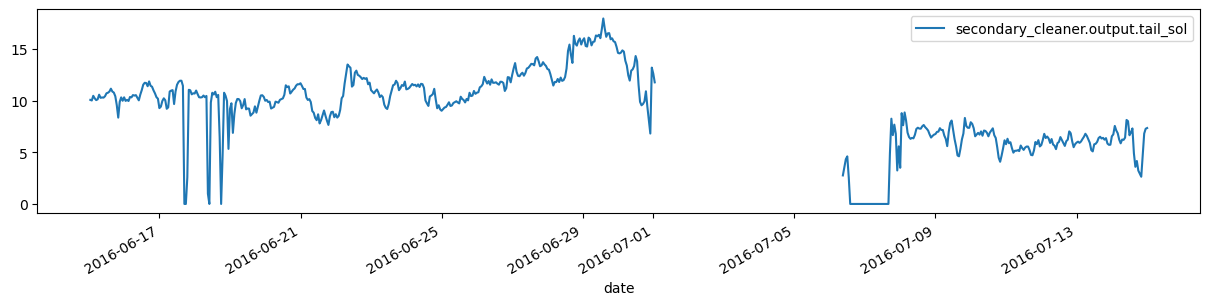

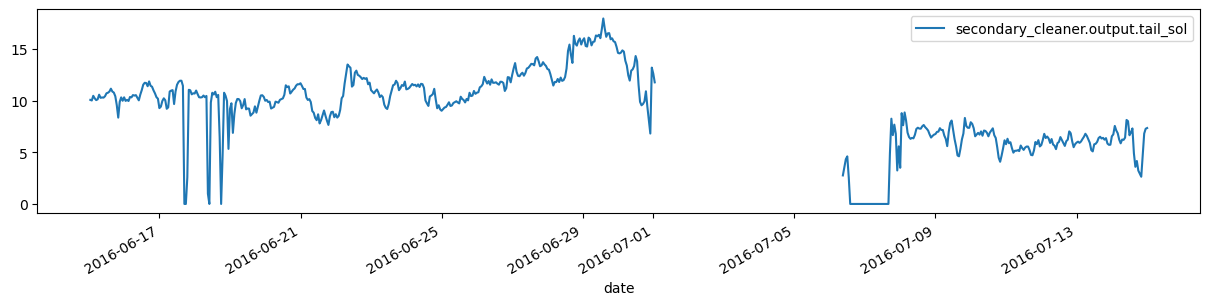

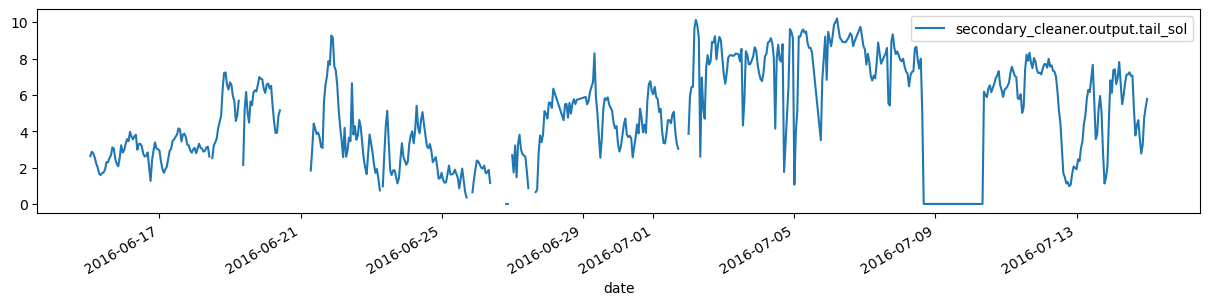

In [29]:
# REVIEW
# Graph "secondary_cleaner.output.tail_sol" and missing values

data.query('date > "2016-06-15" and date <= "2016-07-15"')[['date', 'secondary_cleaner.output.tail_sol']].plot(
    figsize=(15, 3), x='date', y='secondary_cleaner.output.tail_sol')
plt.show()

data_train.query('date > "2016-06-15" and date <= "2016-07-15"')[['date', 'secondary_cleaner.output.tail_sol']].plot(
    figsize=(15, 3), x='date', y='secondary_cleaner.output.tail_sol')
plt.show()

data_test.query('date > "2016-06-15" and date <= "2016-07-15"')[['date', 'secondary_cleaner.output.tail_sol']].plot(
    figsize=(15, 3), x='date', y='secondary_cleaner.output.tail_sol')
plt.show()


In [30]:
# INTERPOLATE

# data
data = data.set_index('date').interpolate(
    method='linear', limit_direction='both')
data.reset_index(inplace=True)

# data_train
data_train = data_train.set_index('date').interpolate(
    method='linear', limit_direction='both')
data_train.reset_index(inplace=True)

# data_test
data_test = data_test.set_index('date').interpolate(
    method='linear', limit_direction='both')
data_test.reset_index(inplace=True)


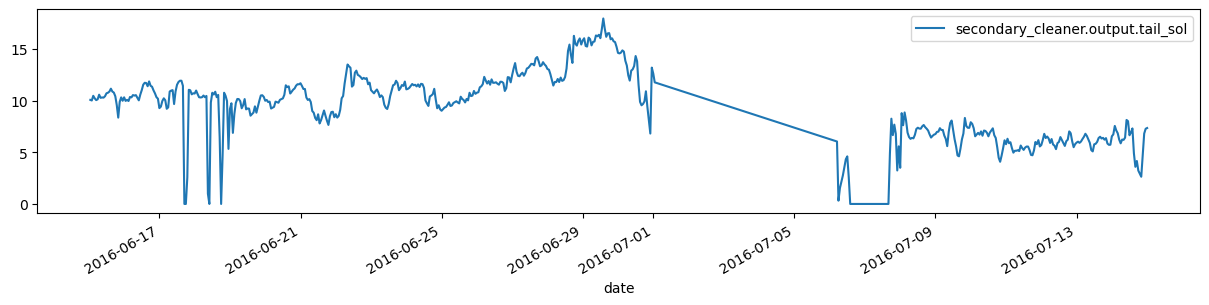

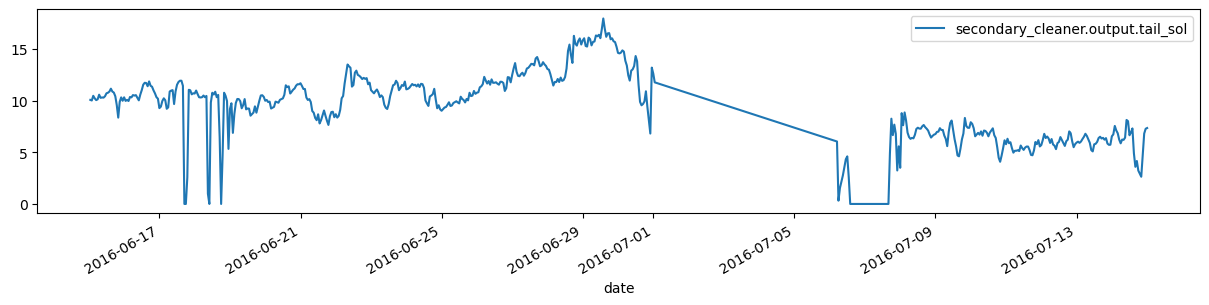

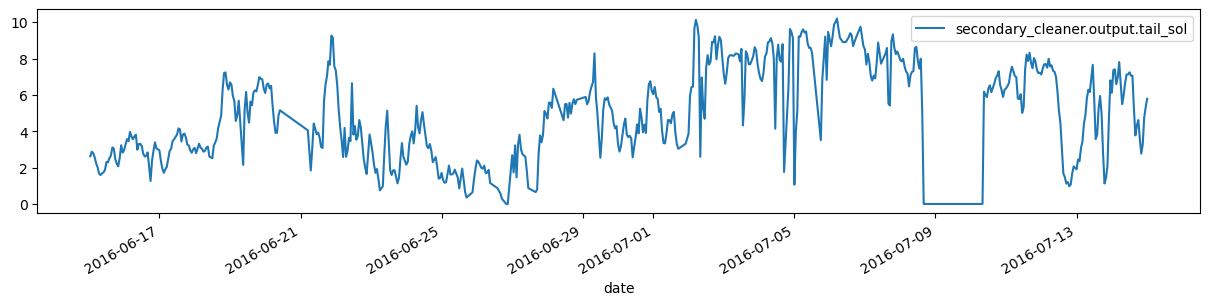

In [31]:
# AFTER
# Graph "secondary_cleaner.output.tail_sol" after fillna using interpolate linear

data.query('date > "2016-06-15" and date <= "2016-07-15"')[['date', 'secondary_cleaner.output.tail_sol']].plot(
    figsize=(15, 3), x='date', y='secondary_cleaner.output.tail_sol')
plt.show()

data_train.query('date > "2016-06-15" and date <= "2016-07-15"')[['date', 'secondary_cleaner.output.tail_sol']].plot(
    figsize=(15, 3), x='date', y='secondary_cleaner.output.tail_sol')
plt.show()

data_test.query('date > "2016-06-15" and date <= "2016-07-15"')[['date', 'secondary_cleaner.output.tail_sol']].plot(
    figsize=(15, 3), x='date', y='secondary_cleaner.output.tail_sol')
plt.show()


In [32]:
print('NaN: ', data.isna().sum().sum(),
      data_train.isna().sum().sum(), data_test.isna().sum().sum())


NaN:  0 0 0


Como podemos observar, hemos rellenado todos los NaN en los 3 datasets.

## Valores atípicos <a id='out'></a>

Revisaremos como se encuentra la distribución de los datos de las variables dependientes:
- `rougher.output.recovery`
- `final.output.recovery`

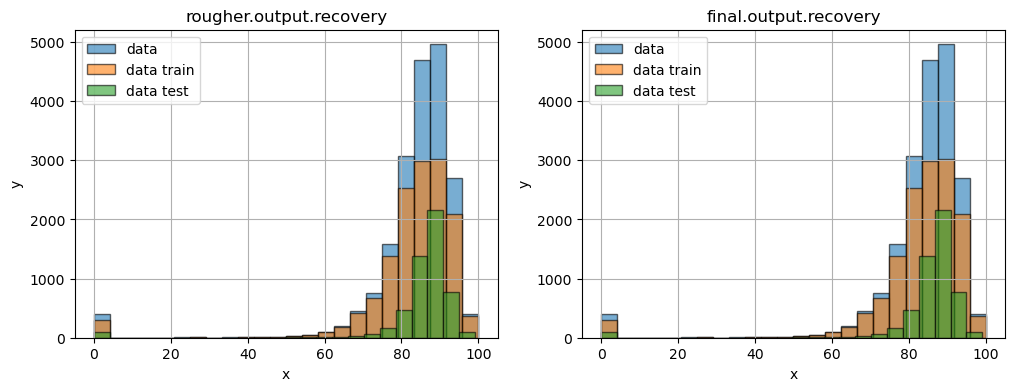

In [33]:
fig, (y_real, b) = plt.subplots(1, 2, figsize=(12, 4))

# Graph
data['rougher.output.recovery'].hist(
    ax=y_real, alpha=0.6, bins=24, label='data', ec='black')
data_train['rougher.output.recovery'].hist(
    ax=y_real, alpha=0.6, bins=24, label='data train', ec='black')
data_test['rougher.output.recovery'].hist(
    ax=y_real, alpha=0.6, bins=24, label='data test', ec='black')
y_real.set_title('rougher.output.recovery')
y_real.legend()
y_real.set_xlabel('x')
y_real.set_ylabel('y')

# Graph
data['rougher.output.recovery'].hist(
    ax=b, alpha=0.6, bins=24, label='data', ec='black')
data_train['rougher.output.recovery'].hist(
    ax=b, alpha=0.6, bins=24, label='data train', ec='black')
data_test['rougher.output.recovery'].hist(
    ax=b, alpha=0.6, bins=24, label='data test', ec='black')
b.set_title('final.output.recovery')
b.legend()
b.set_xlabel('x')
b.set_ylabel('y')

plt.show()


Los histogramas como están distribuidos los datos, nos muestran que existen valores atípicos cercanos al cero. A continuación veamos mediante diagrama de cajas más a detalle y posteriormente eliminaremos los outliers.

Crearemos funciones que usaremos en esta sección exclusivas para limpieza de valores atípicos: "bounds", "outliers", "clean_outliers".

In [34]:
# "bounds" function to calculate upper and lower limits
def bounds(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_min = (Q1 - 1.5 * IQR).astype('int')
    lim_max = (Q3 + 1.5 * IQR).astype('int')

    return [lim_min, lim_max]
    # return a list with 2 values: lower and upper bound

# --------------------------------------------------------

# "outliers" function to find the indices of the outliers


def outliers(df, col):
    min, max = bounds(df, col)
    return df[(df[col] <= min) | (df[col] >= max)].index

# --------------------------------------------------------

# "clean_outliers" function to remove outliers


def clean_outliers(df, col):
    indexes = outliers(df, col)
    df.drop(indexes, inplace=True)


# Columns to clean
columns_selected = ['rougher.output.recovery', 'final.output.recovery']


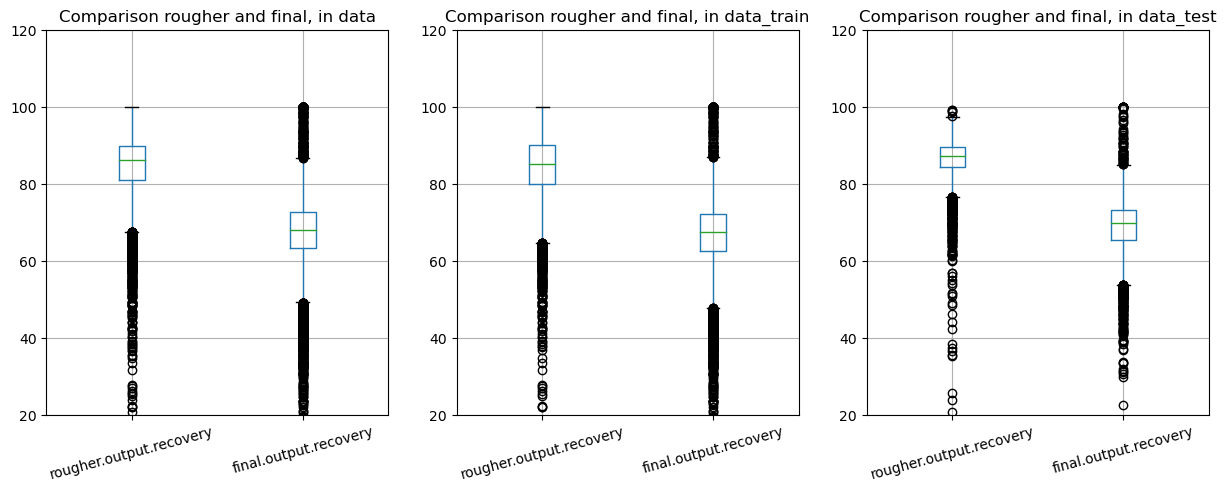

In [35]:
# Graph boxplot of dependent variables in each dataset

fig, (y_real, b, c) = plt.subplots(1, 3, figsize=(15, 5))

data[columns_selected].boxplot(ax=y_real, rot=15)
y_real.set_title('Comparison rougher and final, in data')
y_real.set_ylim(20, 120)

data_train[columns_selected].boxplot(ax=b, rot=15)
b.set_title('Comparison rougher and final, in data_train')
b.set_ylim(20, 120)

data_test[columns_selected].boxplot(ax=c, rot=15)
c.set_title('Comparison rougher and final, in data_test')
c.set_ylim(20, 120)

plt.show()


In [36]:
# Crea una nueva tabla 'data_clean' eliminando los outliers de data

data_clean = data.copy()
total = len(data)
aux = 0

while True:
    # Remove outliers in each column
    for column in columns_selected:
        clean_outliers(data_clean, column)

    total_data_clean = len(data_clean)
    percent = (total - total_data_clean) / total

    # Exits when it can't be cleaned anymore
    if total_data_clean == aux:
        break
    else:
        aux = total_data_clean

print(f'removing outliers in data, total {percent:.2%} \n')


removing outliers in data, total 10.53% 



In [37]:
# Crea una nueva tabla 'data_clean' eliminando los outliers de data

data_train_clean = data_train.copy()
total = len(data_train)
aux = 0

while True:
    # Remove outliers in each column
    for column in columns_selected:
        clean_outliers(data_train_clean, column)

    total_data_clean = len(data_train_clean)
    percent = (total - total_data_clean) / total

    # Exits when it can't be cleaned anymore
    if total_data_clean == aux:
        break
    else:
        aux = total_data_clean

print(f'removing outliers in data_train, total {percent:.2%} \n')


removing outliers in data_train, total 9.39% 



In [38]:
# Crea una nueva tabla 'data_clean' eliminando los outliers de data

data_test_clean = data_test.copy()
total = len(data_test)
aux = 0

while True:
    # Remove outliers in each column
    for column in columns_selected:
        clean_outliers(data_test_clean, column)

    total_data_clean = len(data_test_clean)
    percent = (total - total_data_clean) / total

    # Exits when it can't be cleaned anymore
    if total_data_clean == aux:
        break
    else:
        aux = total_data_clean

print(f'removing outliers in data_test, total {percent:.2%} \n')


removing outliers in data_test, total 12.16% 



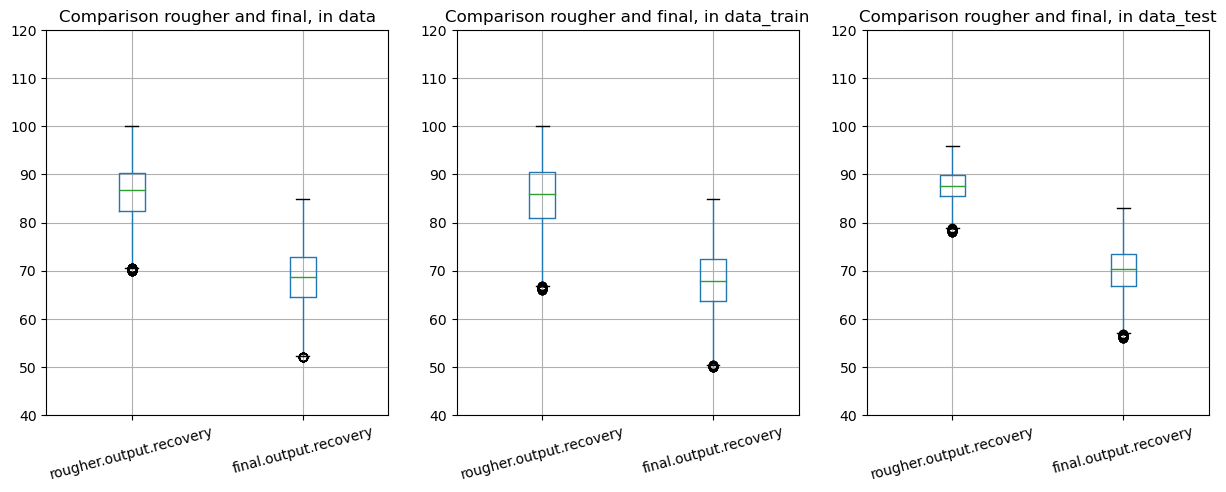

In [39]:
# Graph boxplot of dependent variables in each dataset

fig, (y_real, b, c) = plt.subplots(1, 3, figsize=(15, 5))

data_clean[columns_selected].boxplot(ax=y_real, rot=15)
y_real.set_title('Comparison rougher and final, in data')
y_real.set_ylim(40, 120)

data_train_clean[columns_selected].boxplot(ax=b, rot=15)
b.set_title('Comparison rougher and final, in data_train')
b.set_ylim(40, 120)

data_test_clean[columns_selected].boxplot(ax=c, rot=15)
c.set_title('Comparison rougher and final, in data_test')
c.set_ylim(40, 120)

plt.show()


Como observamos, hemos removido los valores atípicos de nuestras variables dependientes en todos los dataset. Tenemos nuestros dataset limpios y esto es un plus a la hora de entrenar nuestros modelos predictivos. Los nombres de los dataset con que trabajaremos ahora son: 
- `data_clean`, 
- `data_train_clean`, 
- `data_test_clean`.

# Análisis de datos <a id='eda'></a>

Observemos cómo cambia la concentración de metales Oro, Plata y Plomo(Au, Ag, Pb) en función de la etapa de purificación. 

Para ello, escogeremos una muestra de tiempo de datos pequeño, para tener una vista más clara en los gráficos.

In [40]:
begin = "2017-12-01 00:00:00"
end = "2017-12-15 00:00:00"

au = data_clean[['date', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_au']].query(
    'date > @begin and date <= @end').set_index(keys='date')  # Gold
ag = data_clean[['date', 'primary_cleaner.output.concentrate_ag', 'secondary_cleaner.output.tail_ag']].query(
    'date > @begin and date <= @end').set_index(keys='date')  # Silver
pb = data_clean[['date', 'primary_cleaner.output.concentrate_pb', 'secondary_cleaner.output.tail_pb']].query(
    'date > @begin and date <= @end').set_index(keys='date')  # Lead


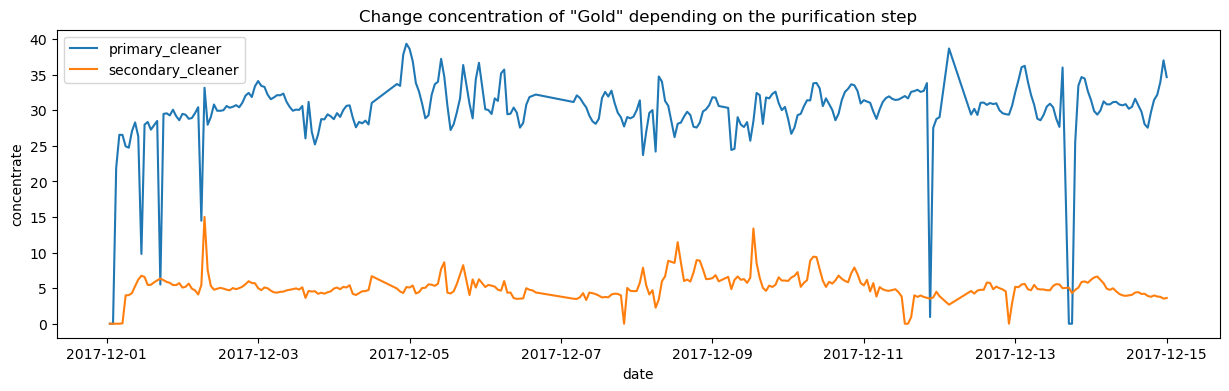

In [41]:
plt.figure(figsize=(15, 4))
plt.plot(au, label=['primary_cleaner', 'secondary_cleaner'])
plt.title('Change concentration of "Gold" depending on the purification step')
plt.legend()
plt.xlabel('date')
plt.ylabel('concentrate')
plt.show()


La concentración de oro es mayor en la primera etapa de limpieza que en la segunda etapa de limpieza.

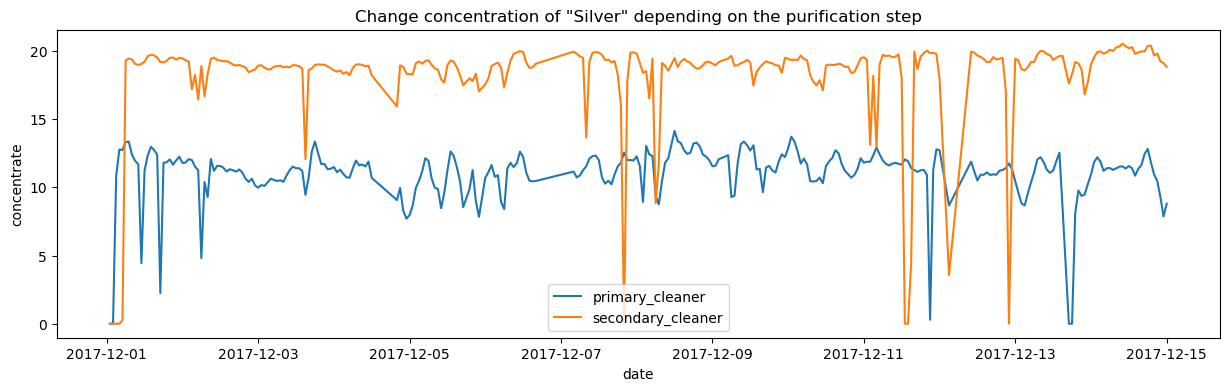

In [42]:
plt.figure(figsize=(15, 4))
plt.plot(ag, label=['primary_cleaner', 'secondary_cleaner'])
plt.title('Change concentration of "Silver" depending on the purification step')
plt.legend()
plt.xlabel('date')
plt.ylabel('concentrate')
plt.show()


Al contrario del oro, la concentración de plata es menor en la primera etapa de limpieza que en la segunda etapa de limpieza.

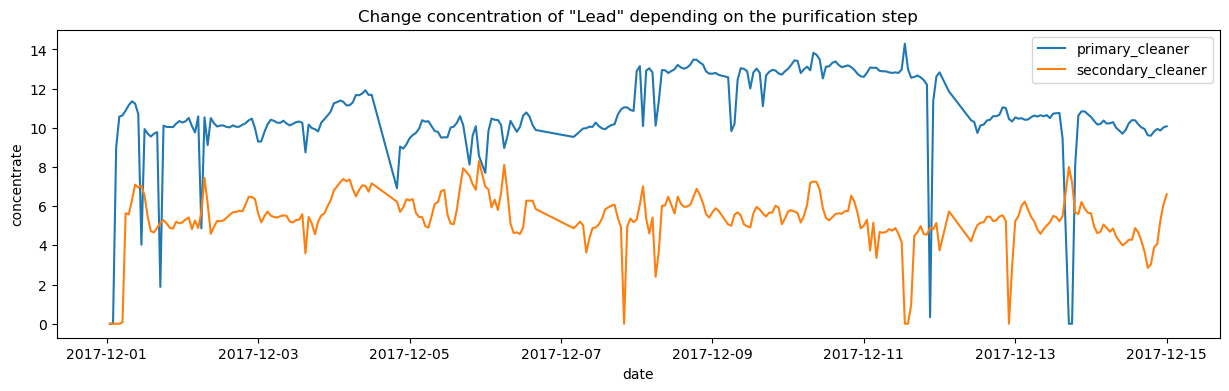

In [43]:
plt.figure(figsize=(15, 4))
plt.plot(pb, label=['primary_cleaner', 'secondary_cleaner'])
plt.title('Change concentration of "Lead" depending on the purification step')
plt.legend()
plt.xlabel('date')
plt.ylabel('concentrate')
plt.show()


Al igual que el oro, la concentración de plomo es mayor en la primera etapa de limpieza que en la segunda etapa de limpieza.

Compararemos las distribuciones del *tamaño de las partículas de la alimentación* "`feed size`" en el conjunto de entrenamiento y en el conjunto de prueba. Si las distribuciones varían significativamente, la evaluación del modelo no será correcta.

In [44]:
feed_size = data_train.columns[data_train.columns.str.contains(
    'feed_size')].tolist()
feed_size


['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

Las columnas que vamos a evaluar son: 
- '`primary_cleaner.input.feed_size`'
- '`rougher.input.feed_size`'

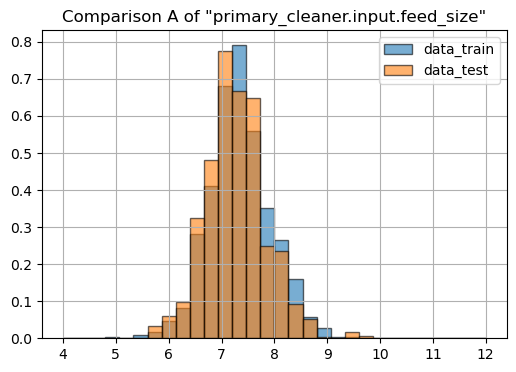

In [45]:
data_train_clean[feed_size[0]].hist(figsize=(
    6, 4), density=True, ec='black', alpha=0.6, bins=30, range=(4, 12), label='data_train')
data_test_clean[feed_size[0]].hist(figsize=(
    6, 4), density=True, ec='black', alpha=0.6, bins=30, range=(4, 12), label='data_test')
plt.title('Comparison A of "primary_cleaner.input.feed_size"')
plt.legend()
plt.show()


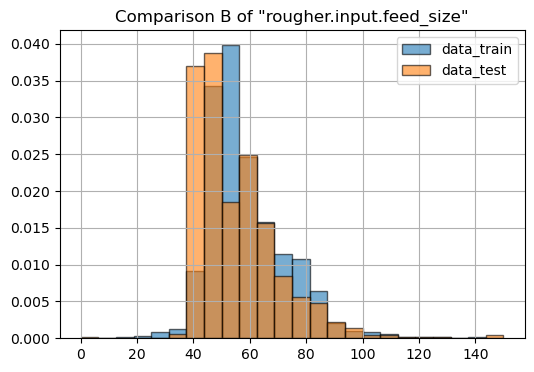

In [46]:
data_train_clean[feed_size[1]].hist(figsize=(
    6, 4), density=True, ec='black', alpha=0.6, bins=24, range=(0, 150), label='data_train')
data_test_clean[feed_size[1]].hist(figsize=(
    6, 4), density=True, ec='black', alpha=0.6, bins=24, range=(0, 150), label='data_test')
plt.title('Comparison B of "rougher.input.feed_size"')
plt.legend()
plt.show()


Hemos comparados los valores de las distribuciones del *tamaño de las partículas de la alimentación* (`primary_cleaner.input.feed_size`, `rougher.input.feed_size`) y podemos indicar que son parecidas, no se notan cambios significativos en las distribuciones tanto en el conjunto de datos de entrenamiento, como en el conjunto de datos de prueba.

Consideremos las concentraciones totales de todas las sustancias (oro, plata, plomo) en las diferentes etapas: materia prima, concentrado rougher y concentrado final.

In [47]:
# Create "summary_metals" table
col = ['metal', 'rougher.input.feed',
       'rougher.output.concentrate', 'final.output.concentrate']
summary_metals = pd.DataFrame(columns=col).set_index(keys=['metal'])
summary_metals


,rougher.input.feed,rougher.output.concentrate,final.output.concentrate
metal,,,


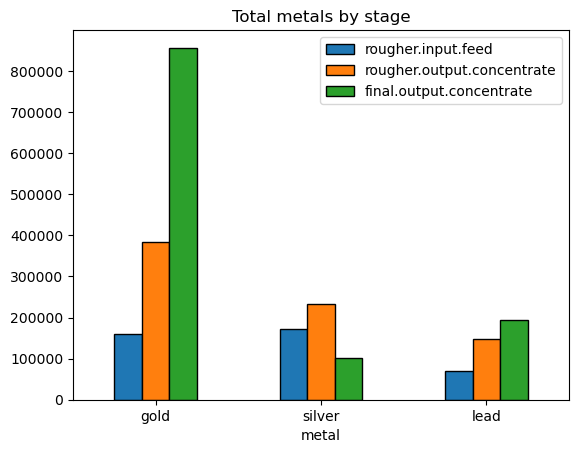

In [48]:
# Data totals au, ag, pb per stage
au_total = round(data[['rougher.input.feed_au',
                 'rougher.output.concentrate_au', 'final.output.concentrate_au']].sum(), 2)
ag_total = round(data[['rougher.input.feed_ag',
                 'rougher.output.concentrate_ag', 'final.output.concentrate_ag']].sum(), 2)
pb_total = round(data[['rougher.input.feed_pb',
                 'rougher.output.concentrate_pb', 'final.output.concentrate_pb']].sum(), 2)

# Save totals in summary_metals
summary_metals.loc['gold'] = {'rougher.input.feed': au_total[0],
                              'rougher.output.concentrate': au_total[1], 'final.output.concentrate': au_total[2]}
summary_metals.loc['silver'] = {'rougher.input.feed': ag_total[0],
                                'rougher.output.concentrate': ag_total[1], 'final.output.concentrate': ag_total[2]}
summary_metals.loc['lead'] = {'rougher.input.feed': pb_total[0],
                              'rougher.output.concentrate': pb_total[1], 'final.output.concentrate': pb_total[2]}

# Graph
summary_metals.plot(kind='bar', rot=0, ec='black')
plt.title('Total metals by stage')
plt.show()


Podemos observar las concentraciones totales (gold, silver, lead) en las 3 etapas: 
- etapa 1: materia prima (rougher.input.feed), 
- etapa 2: concentrado rougher (rougher.output.concentrate) y 
- etapa 3: concentrado final (final.output.concentrate). 

El comportamiento  de las 3 etapas coincide en oro y plomo. En cambio en plata el concentrado final disminuye significativamente por debajo de la etapa inicial de materia prima.

# Entrenamiento de modelos <a id='ent'></a>

Establecemos las variables features para establecer las caracteristicas, ademas target_rougher y target_final para establecer los objetivos

In [49]:
# data_train
features_train = data_train_clean.drop(
    ['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher_train = data_train_clean['rougher.output.recovery']
target_final_train = data_train_clean['final.output.recovery']

print(
    f'size data_train {features_train.shape, target_rougher_train.shape, target_final_train.shape}')

# data_test
features_test = data_test_clean.drop(
    ['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher_test = data_test_clean['rougher.output.recovery']
target_final_test = data_test_clean['final.output.recovery']

print(
    f'size data_test  {features_test.shape, target_rougher_test.shape, target_final_test.shape}')


size data_train ((12821, 84), (12821,), (12821,))
size data_test  ((4647, 84), (4647,), (4647,))


Crearemos un función para calcular la métrica sMAPE que nos permitirá evaluar la calidad del modelo.

### Calcula sMAPE

Fórmula para medir la calidad del modelo, usaremos sMAPE (error medio absoluto porcentual simétrico):

$$
sMAPE = \frac {1} {n} \sum _ { i=1 } ^ { n } \frac { |y_i - \hat{y_i}| } {\frac{|y_i| + |\hat{y_i}|}{2} } * 100\%
$$

$$
sMAPE final = 25\% * sMAPE(rougher) + 75\% * sMAPE(final)
$$

In [50]:
# Function sMAPE

def smape(y_real, y_predict):
    return 1 / len(y_real) * np.sum(2 * np.abs(y_real - y_predict) / (np.abs(y_real) + np.abs(y_predict))) * 100

# Function sMAPE final


def smape_final(rougher, final):
    return (0.25 * rougher) + (0.75 * final)


# Customer score "smape"
smape_score = met.make_scorer(smape, greater_is_better=False)


Entrenaremos diferentes modelos, y evaluaremos aplicando la validación cruzada. La métrica de evaluación es "smape". Después eligiremos el mejor modelo y lo probaremos utilizando la muestra de prueba.

In [51]:
summary_models = pd.DataFrame(columns=['target', 'model', 'score'])
summary_models


,target,model,score


In [52]:
# training models with "LinearRegression"

X = features_train
Y = [target_rougher_train,
     target_final_train]

for y in Y:
    print(f'Prediction target: "{y.name}"')
    model = LinearRegression()

    #  calculate the scores with function "cross_val_score" with 5 blocks
    scores = cross_val_score(model, X, y, cv=5, scoring=smape_score)
    mean_score = -1 * scores.mean()

    # print(f'scores: {scores}')
    print(f'   Mean score of the model evaluation: {mean_score:.4f}\n')

    model.fit(X, y)

    # save the results
    summary_models.loc[f'model {len(summary_models)+1}'] = {
        'target': y.name, 'model': model, 'score': mean_score}
summary_models


Prediction target: "rougher.output.recovery"
   Mean score of the model evaluation: 2.0032

Prediction target: "final.output.recovery"
   Mean score of the model evaluation: 1.9562



,target,model,score
model 1,rougher.output.recovery,LinearRegression(),2.003211
model 2,final.output.recovery,LinearRegression(),1.956238


In [53]:
# training models with "DecisionTreeRegressor"

X = features_train
Y = [target_rougher_train,
     target_final_train]

for y in Y:
    best_score = float('inf')
    print(f'Prediction target: "{y.name}"')

    for depth in [15, 23]:

        model = DecisionTreeRegressor(random_state=12345, max_depth=depth)

        #  calculate the scores with function "cross_val_score" with 5 blocks
        scores = cross_val_score(model, X, y, cv=5, scoring=smape_score)

        mean_score = -1 * scores.mean()
        print(mean_score)

        if mean_score < best_score:
            best_score = mean_score
            best_model = model.fit(X, y)

    display(best_model)
    print(f'   MAE mean score: {best_score:.4f}\n')
    print()

    # guardamos los resultados
    summary_models.loc[f'model {len(summary_models)+1}'] = {
        'target': y.name, 'model': best_model, 'score': best_score}
summary_models


Prediction target: "rougher.output.recovery"
1.935809748454636
1.8946548250233655


DecisionTreeRegressor(max_depth=23, random_state=12345)

   MAE mean score: 1.8947


Prediction target: "final.output.recovery"
1.4552497246506788
1.5286783637652301


DecisionTreeRegressor(max_depth=15, random_state=12345)

   MAE mean score: 1.4552




,target,model,score
model 1,rougher.output.recovery,LinearRegression(),2.003211
model 2,final.output.recovery,LinearRegression(),1.956238
model 3,rougher.output.recovery,"DecisionTreeRegressor(max_depth=23, random_sta...",1.894655
model 4,final.output.recovery,"DecisionTreeRegressor(max_depth=15, random_sta...",1.455250


In [54]:
# training models with "RandomForestRegressor"

X = features_train
Y = [target_rougher_train,
     target_final_train]

for y in Y:
    best_score = float('inf')
    print(f'Prediction target: "{y.name}"')

    for depth in [13, 15]:

        model = RandomForestRegressor(
            random_state=12345, n_estimators=15, max_depth=depth)

        #  calculate the scores with function "cross_val_score" with 5 blocks
        scores = cross_val_score(model, X, y, cv=5, scoring=smape_score)

        mean_score = -1 * scores.mean()
        print(mean_score)

        if mean_score < best_score:
            best_score = mean_score
            best_model = model.fit(X, y)

    display(best_model)
    print(f'   MAE mean score: {best_score:.4f}\n')
    print()

    # guardamos los resultados
    summary_models.loc[f'model {len(summary_models)+1}'] = {
        'target': y.name, 'model': best_model, 'score': best_score}
summary_models


Prediction target: "rougher.output.recovery"
1.2384832232080178
1.2346762033773875


RandomForestRegressor(max_depth=15, n_estimators=15, random_state=12345)

   MAE mean score: 1.2347


Prediction target: "final.output.recovery"
0.9772277856904484
0.9798412058453918


RandomForestRegressor(max_depth=13, n_estimators=15, random_state=12345)

   MAE mean score: 0.9772




,target,model,score
model 1,rougher.output.recovery,LinearRegression(),2.003211
model 2,final.output.recovery,LinearRegression(),1.956238
model 3,rougher.output.recovery,"DecisionTreeRegressor(max_depth=23, random_sta...",1.894655
model 4,final.output.recovery,"DecisionTreeRegressor(max_depth=15, random_sta...",1.455250
model 5,rougher.output.recovery,"(DecisionTreeRegressor(max_depth=15, max_featu...",1.234676
model 6,final.output.recovery,"(DecisionTreeRegressor(max_depth=13, max_featu...",0.977228


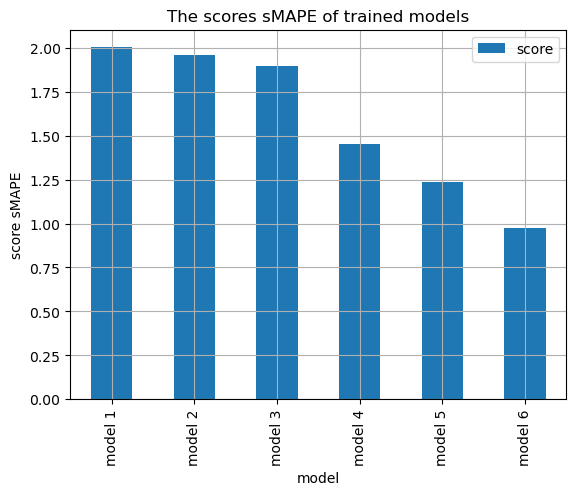

In [55]:
summary_models.plot(kind='bar', grid=True)
plt.title('The scores sMAPE of trained models')
plt.xlabel('model')
plt.ylabel('score sMAPE')
plt.show()


Hemos visto un resumen de nuestros modelos entrenados, y sabemos que los mejores modelos son el 5 y el 6 entrenados con *Random Forest Regressor*, evaluados con la métrica sMAPE. 
- model 5 para predecir 'rougher.output.recovery': RandomForestRegressor (max_depth=15, n_estimators=15, random_state=12345)
- model 6 para precedir 'final.output.recovery'  : RandomForestRegressor(max_depth=13, n_estimators=15, random_state=12345)

Ahora vamos a comprobar nuestros mejores modelos en nuestro dataset de prueba.

In [56]:
# Get the models saved in summary_models table

model_rougher = summary_models.loc['model 5'].model
model_final = summary_models.loc['model 6'].model

# Prediction for test data using "features_test"
prediction_rougher = model_rougher.predict(features_test)
prediction_final = model_final.predict(features_test)

# Metric sMAPE for rougher and final
rougher = smape(target_rougher_test, prediction_rougher)
final = smape(target_final_test, prediction_final)

# Calculate metric sMAPE Final
smape_final_ = smape_final(rougher, final)

print(f'sMAPE Final {smape_final_}')


sMAPE Final 0.6202084635128084


Hemos obtenido nuestro sMAPE final de 0.62 en nuestro dataset de prueba, este score nos permite evidenciar que nuestro modelo se ajustó muy bien y la calidad de las predicciones tienen un margen de error bajo.

# Conclusiones <a id='con'></a>

Trabajamos con los dataset en las etapas de preparación de datos, preprocesamiento de datos, análisis de datos y entrenamiento de modelos de machine learning para predicciones de regresión.

En el proceso podemos indicar las siguientes acciones más relevantes:
- Comprobamos que el cálculo de la recuperación de "rougher.output.recovery" es correcto en el dataset de entrenamiento, usamos la métrica MAE con la que pudimos medir el margen de error de 0.

- El dataset de prueba data_test le faltaban 34 columnas las cuales fueron agregadas desde el dataset original.

- Se trataron valores ausentes:
    - NaN en las variables dependientes "rougher.output.recovery" y "final.output.recovery" se eliminaron los NaN.
    - NaN en las variables independientes se rellenaron usando interpolación lineal.

- Se limpiaron valores atípicos en nuestras variables dependientes.

- En el análisis de datos pudimos revisar las concentraciones de metales en función a las etapas de purificación, obteniendo lo siguiente:
    - La concentración de oro es mayor en la primera etapa de limpieza que en la segunda etapa de limpieza.
    - Al contrario del oro, la concentración de plata es menor en la primera etapa de limpieza que en la segunda etapa de limpieza.
    - Al igual que el oro, la concentración de plomo es mayor en la primera etapa de limpieza que en la segunda etapa de limpieza.

- También comparamos los valores de las distribuciones del *tamaño de las partículas de la alimentación* (`primary_cleaner.input.feed_size`, `rougher.input.feed_size`) y podemos indicar que son parecidas, no se notan cambios significativos en las distribuciones tanto en el conjunto de datos de entrenamiento, como en el conjunto de datos de prueba.

- El comportamiento  de las 3 etapas (materia prima, concentrado rougher y concentrado final) coincide en oro y plomo. En cambio en plata el concentrado final disminuye significativamente por debajo de la etapa inicial de materia prima.

**Entrenamiento de modelos predictivos:**

Entrenamos varios modelos y aplicando la validación cruzada pudimos evaluar usando la métrica "smape". Los mejores modelos fueron el modelo 5 y 6 que se detallan a continuación:
- model 5 predice 'rougher.output.recovery'
    - RandomForestRegressor (max_depth=15, n_estimators=15, random_state=12345)
- model 6 predice 'final.output.recovery' 
    - RandomForestRegressor(max_depth=13, n_estimators=15, random_state=12345)

Confirmamos la calidad de nuestro modelo predictivo en nuestro dataset de prueba y obtuvimos un sMAPE final de **0.62**, este score nos permite evidenciar que nuestro modelo se ajustó muy bien y la calidad de las predicciones tienen un margen de error bajo. Por lo que la empresa Zyfra podrá hacer uso de este prototipo de modelo de machine learning para predecir la cantidad de oro extraido.